# Example 1: Cepstral Analysis of solid amorphous Silica
This example shows the basic usage of *thermocepstrum* to compute the thermal conductivity of a classical MD simulation of a-SiO$_2$.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
try:
    import thermocepstrum as tc
except ImportError:
    from sys import path
    path.append('..')
    import thermocepstrum as tc

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib notebook

## 1. Load trajectory
Read the heat current from a simple column-formatted file. The desired columns are selected based on their header (e.g. with LAMMPS format).

For other input formats see corresponding the example.

In [3]:
jfile = tc.i_o.TableFile('./data/Silica.dat', group_vectors=True)

# Solid Silica - BKS potential, melted and quenched
# 216 atoms, T~1000K, dens~2.295g/cm^3
# NVE, dt = 1.0 fs, 50 ns, output_step = 1.0 fs
# Temperature = 1065.705630 K, Volume = 3130.431110818 A^3
# LAMMPS metal units
c_flux1[1] c_flux1[2] c_flux1[3]
 #####################################
  all_ckeys =  {'flux1': array([0, 1, 2])}
 #####################################
Data length =  100001


In [4]:
jfile.read_datalines(start_step=0, NSTEPS=0, select_ckeys=['flux1'])

  ckey =  {'flux1': array([0, 1, 2])}
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  0.8407833576202393 seconds


{'flux1': array([[  91.472925,  630.61992 ,  199.16002 ],
        [  71.403952,  666.80601 ,  274.30247 ],
        [  47.754737,  678.10914 ,  305.95706 ],
        ...,
        [ 466.489   , -360.14259 ,  -47.286976],
        [ 414.3014  , -378.42595 ,  166.42152 ],
        [ 331.99113 , -400.35311 ,  378.13009 ]])}

## 2. Heat Current
Define a **HeatCurrent** from the trajectory, with the correct parameters.

In [5]:
DT_FS = 1.0                 # time step [fs]
TEMPERATURE = 1065.705630   # temperature [K]
VOLUME = 3130.431110818     # volume [A^3]

j = tc.HeatCurrent(jfile.data['flux1'], 'metal', DT_FS, TEMPERATURE, VOLUME)

<IPython.core.display.Javascript object>


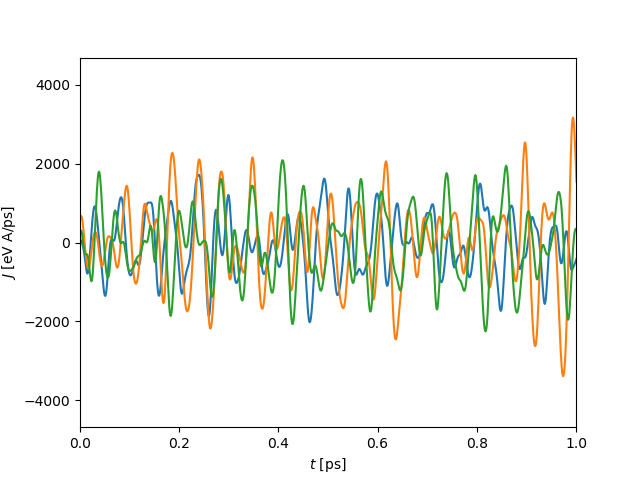

In [6]:
# trajectory
f = plt.figure()
ax = plt.plot(j.timeseries()/1000., j.traj);
plt.xlim([0, 1.0])
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

Compute the **Power Spectral Density** and filter it for visualization.

<IPython.core.display.Javascript object>


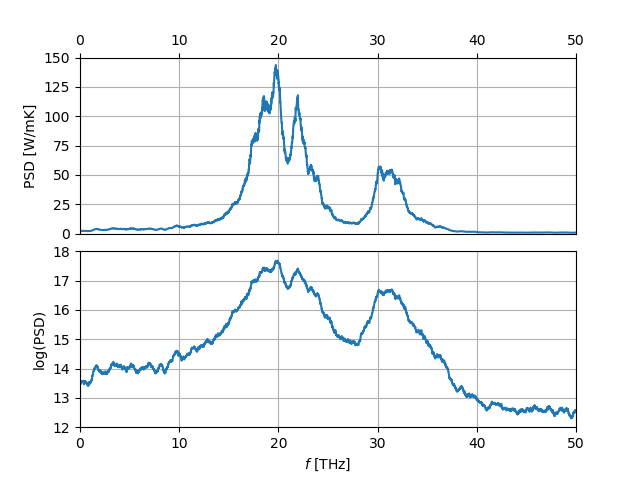

500.0


In [7]:
# Periodogram with given filtering window width
ax = j.plot_periodogram(PSD_FILTER_W=0.5, kappa_units=True)
print (j.Nyquist_f_THz)
plt.xlim([0, 50])
ax[0].set_ylim([0, 150]);
ax[1].set_ylim([12, 18]);

## 3. Resampling
If the Nyquist frequency is very high (i.e. the sampling time is small), such that the log-spectrum goes to low values, you may want resample your time series to obtain a maximum frequency $f^*$.
Before performing that operation, the time series is automatically filtered to reduce the amount of aliasing introduced. Ideally you do not want to go too low in $f^*$. In an intermediate region the results should not change. 

To perform resampling you can choose the resampling frequency $f^*$ or the resampling step (`TSKIP`). If you choose $f^*$, the code will try to choose the closest value allowed.
The resulting PSD is visualized to ensure that the low-frequency region is not affected. 

<IPython.core.display.Javascript object>


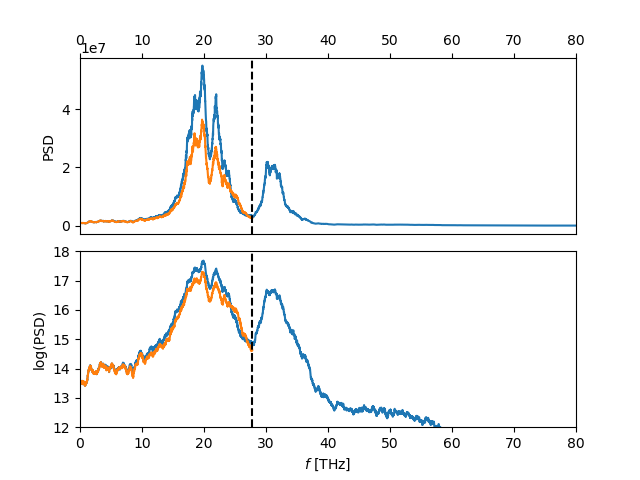

-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      27.77778 THz
 Sampling time         TSKIP =            18 steps
                             =        18.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2778
 PSD      @cutoff  (pre-filter) = 3173093.88767
                  (post-filter) = 2635454.95726
 log(PSD) @cutoff  (pre-filter) =     14.79703
                  (post-filter) =     14.62837
 min(PSD)          (pre-filter) =      0.97609
 min(PSD)         (post-filter) =  62691.79433
 % of original PSD Power f<f* (pre-filter)  = 77.028880
-----------------------------------------------------



In [8]:
FSTAR_THZ = 28.0
jf, ax = tc.heatcurrent.resample_current(j, fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 80])
ax[1].set_ylim([12,18]);

<IPython.core.display.Javascript object>


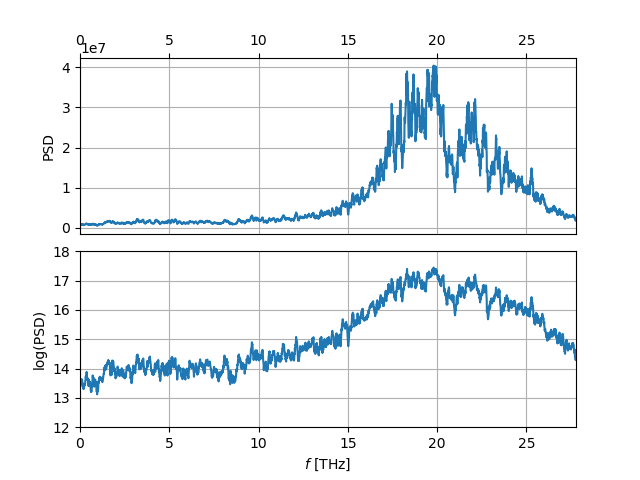

In [9]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[1].set_ylim([12, 18]);

## 4. Cepstral Analysis
Perform Cepstral Analysis. The code will:
 1. the parameters describing the theoretical distribution of the PSD are computed
 2. the Cepstral coefficients are computed by Fourier transforming the log(PSD)
 3. the Akaike Information Criterion is applied
 4. the resulting $\kappa$ is returned

In [10]:
jf.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 37  (P* = 38, corr_factor = 1.000000)
  L_0*   =          13.395456 +/-   0.103277
  S_0*   =      950203.538450 +/- 98134.481881
-----------------------------------------------------
  kappa* =           2.484534 +/-   0.256596  W/mK
-----------------------------------------------------



In [11]:
# Cepstral Coefficients
print 'c_k = ', jf.dct.logpsdK

ax = jf.plot_ck()
ax.set_xlim([0, 50])
ax.set_ylim([-0.5, 0.5])
ax.grid();

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('c_k = ', jf.dct.logpsdK)? (<ipython-input-11-ed9ba0c68e24>, line 2)

In [22]:
# AIC function
f = plt.figure()
plt.plot(jf.dct.aic, '.-', c=c[0])
plt.xlim([0, 200])
plt.ylim([2800, 3000]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

SyntaxError: invalid syntax (<ipython-input-22-9d8ebc050a56>, line 7)

Plot the thermal conductivity $\kappa$ as a function of the cutoff $P^*$

In [23]:
# L_0 as a function of cutoff K
ax = jf.plot_L0_Pstar()
ax.set_xlim([0, 200])
ax.set_ylim([12.5, 14.5]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

SyntaxError: invalid syntax (<ipython-input-23-d4cfb4fcf01e>, line 6)

<IPython.core.display.Javascript object>


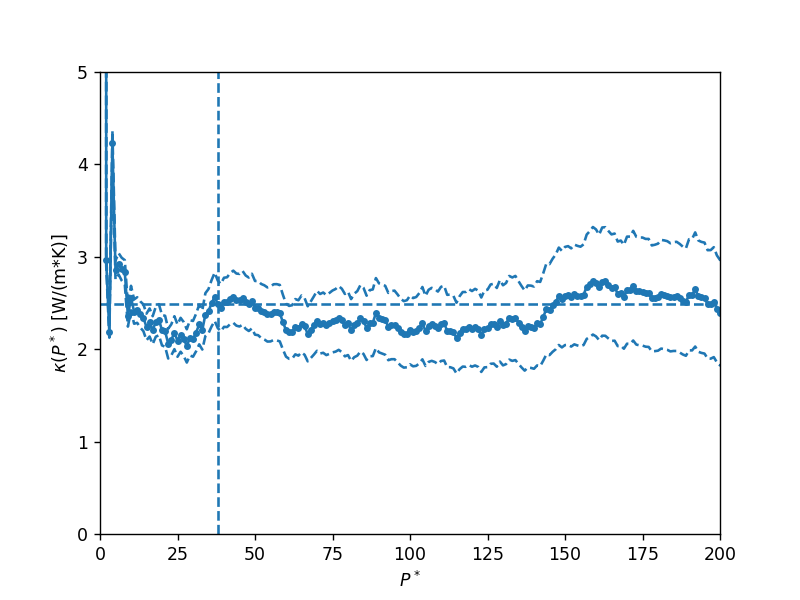

K of AIC_min = 37
AIC_min = 2820.804281


In [24]:
# kappa as a function of cutoff K
ax = jf.plot_kappa_Pstar()
ax.set_xlim([0,200])
ax.set_ylim([0, 5.0]);

print ('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print ('AIC_min = {:f}'.format(jf.dct.aic_min))

Print the results :)

In [25]:
print(jf.cepstral_log)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 37  (P* = 38, corr_factor = 1.000000)
  L_0*   =          13.395456 +/-   0.103277
  S_0*   =      950203.538450 +/- 98134.481881
-----------------------------------------------------
  kappa* =           2.484534 +/-   0.256596  W/mK
-----------------------------------------------------



You can now visualize the filtered PSD...

<IPython.core.display.Javascript object>


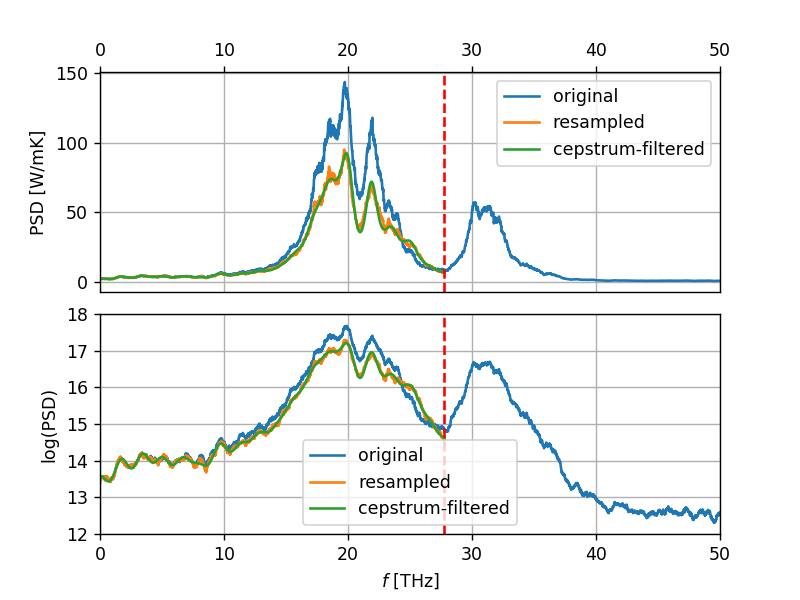

In [26]:
# filtered log-PSD
ax = j.plot_periodogram(0.5, kappa_units=True)
ax = jf.plot_periodogram(0.5, axes=ax, kappa_units=True)
ax = jf.plot_cepstral_spectrum(axes=ax, kappa_units=True)
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
ax[1].set_ylim([12,18])
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);